In [1]:
import argparse
import pickle
import torch
import os
import glob
import re

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import pandas as pd
from pathlib import Path
from statistics import mean

from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from beautifultable import BeautifulTable
from pathlib import Path
from incremental_rl.train import IncrementalExpt, set_one_thread
from sys import platform
if platform == "darwin":
    import matplotlib as mpl
    mpl.use("Qt5Agg")

# colors = dict(mcolors.BASE_COLORS, **mcolors.CSS4_COLORS)
colors = dict(mcolors.BASE_COLORS, **mcolors.XKCD_COLORS)
colors = list(colors.keys())
colors.remove('w')

/home/vasan/src/rtrl/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Set dimensions in the background of matplotlib. Call both functions for pretty plots :) 

def setsizes():
    plt.rcParams['axes.linewidth'] = 1.0
    plt.rcParams['lines.markeredgewidth'] = 1.0
    plt.rcParams['lines.markersize'] = 3

    plt.rcParams['xtick.labelsize'] = 14.0
    plt.rcParams['ytick.labelsize'] = 14.0
    plt.rcParams['xtick.direction'] = "out"
    plt.rcParams['ytick.direction'] = "in"
    plt.rcParams['lines.linewidth'] = 3.0
    plt.rcParams['ytick.minor.pad'] = 50.0

    # https://tex.stackexchange.com/questions/18687/how-to-generate-pdf-without-any-type3-fonts
    plt.rcParams['pdf.fonttype'] = 42   

def setaxes():
    plt.gcf().subplots_adjust(bottom=0.2)
    plt.gcf().subplots_adjust(left=0.2)
    ax = plt.gca()
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    # ax.spines['left'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.tick_params(axis='both', direction='out', which='minor', width=2, length=3,
                   labelsize=12, pad=8)
    ax.tick_params(axis='both', direction='out', which='major', width=2, length=8,
                   labelsize=12, pad=8)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)
    for tick in ax.xaxis.get_major_ticks():
        # tick.label.set_fontsize(getxticklabelsize())
        tick.label.set_fontsize(14)
    for tick in ax.yaxis.get_major_ticks():
        # tick.label.set_fontsize(getxticklabelsize())
        tick.label.set_fontsize(14)

def plt_formatter():
    setsizes()
    setaxes()

In [3]:
### Helper functions to generate plots for the paper

# Assign colors for each choice of timeout
color_dict = {
    # simulation colors
    1:      'tab:blue',
    2:      'tab:orange',
    5:      'tab:green',
    10:     'tab:red',
    25:     'tab:purple', 
    50:     'tab:brown', 
    100:    'tab:pink', 
    500:    'tab:gray', 
    1000:   'tab:olive', 
    5000:   'tab:cyan',
    # real robot colors
    '3s':      'tab:blue',
    '6s':      'tab:orange',
    '15s':     'tab:red',
    '30s':     'tab:green',
}

def human_format_numbers(num, use_float=False):
    # Make human readable short-forms for large numbers
    magnitude = 0
    while abs(num) >= 1000:
        magnitude += 1
        num /= 1000.0
    # add more suffixes if you need them
    if use_float:
        return '%.2f%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])
    return '%d%s' % (num, ['', 'K', 'M', 'G', 'T', 'P'][magnitude])


def set_labels(title, xlabel="Timesteps", ylabel="Return", labelpad=25):
    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    h = plt.ylabel(ylabel, fontsize=14, labelpad=labelpad)
    h.set_rotation(0)
    (ticks, texts) = plt.xticks()
    try:
        new_labels = [human_format_numbers(int(k.get_text())) for k in texts]
    except:
        new_labels = [human_format_numbers(int(k)) for k in ticks]
    plt.xticks(ticks=ticks, labels=new_labels)
    plt.grid()
    plt.tight_layout()


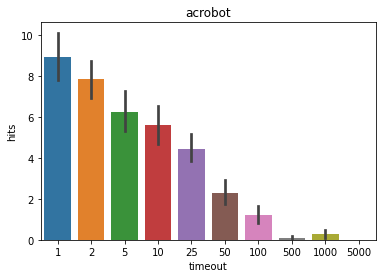

In [10]:
# Plots hits vs timeouts

### Configurable params
env = "acrobot"
bp = "/home/vasan/src/rl_suite/rl_suite/plot"
fp = bp + f"/{env}_random_stat.txt"
###

df = pd.DataFrame(columns=["timeout", "seed", "hits"])
with open(fp, 'r') as file:
    for line in file.readlines():
        match = re.match(r"timeout=(\d+), seed=(\d+): (\d+)", line)
        timeout = match.group(1)
        seed = match.group(2)
        hits = match.group(3)
        df = pd.concat([df, pd.DataFrame.from_records([{'timeout': int(timeout), 'seed':int(seed), 'hits': int(hits)}])])
        
plt.title(env)
plt.xlabel('Timeout')
plt.ylabel('Hits')
ax = sns.barplot(data=df, x='timeout', y='hits')

# Labels over each bar
# ax.bar_label(ax.containers[0], fmt="%.2f", label_type="center")
    
# plt.savefig(f'{env}.png')
plt.show()
plt.close()


In [4]:
def smoothed_curve(returns, ep_lens, x_tick=5000, window_len=5000):
    """
    Args:
        returns: 1-D numpy array with episodic returs
        ep_lens: 1-D numpy array with episodic returs
        x_tick (int): Bin size
        window_len (int): Length of averaging window
    Returns:
        A numpy array
    """
    rets = []
    x = []
    cum_episode_lengths = np.cumsum(ep_lens)

    if cum_episode_lengths[-1] >= x_tick:
        y = cum_episode_lengths[-1] + 1
        steps_show = np.arange(x_tick, y, x_tick)

        for i in range(len(steps_show)):
            rets_in_window = returns[(cum_episode_lengths > max(0, x_tick * (i + 1) - window_len)) *
                                     (cum_episode_lengths < x_tick * (i + 1))]
            if rets_in_window.any():
                rets.append(np.mean(rets_in_window))
                x.append((i+1) * x_tick)

    return np.array(rets), np.array(x)

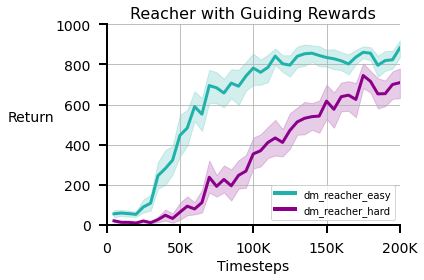

In [31]:
# Plot returns from numpy txt files with returns and episode lengths

# envs = ["gr_reacher_easy", "gr_reacher_hard"]
envs = ["reacher_easy", "reacher_hard"]
color_palette = {
    "reacher_easy": "lightseagreen",
    "reacher_hard": "darkmagenta",
}
timeouts = [1000]
seed = 10

df = pd.DataFrame(columns=["step", "avg_ret", "seed", "timeout"])

for env in envs:
    for timeout in timeouts:
        all_paths = glob.glob(f"/home/vasan/scratch/min_time_paper/{env}/timeout={timeout}/returns/*_returns.txt")
        assert len(all_paths) > 0
        counter = 0
        for fp in all_paths:
            counter += 1
            data = np.loadtxt(fp)
            try:
                rets, timesteps = smoothed_curve(data[1], data[0], x_tick=5000, window_len=5000)
                for r, t in zip(rets, timesteps):
                    df = pd.concat([df, pd.DataFrame.from_records([{'env': env, 'timeout': timeout, 'seed':counter, 'step':t, 'avg_ret':r}])])
            except IndexError as e:
                print(f"Run {fp} incomplete. It was not added to the plot")

for timeout in timeouts:
    plt.figure()
    plt_formatter()
    plt.xlim(0, 200000)
    plt.ylim(0, timeout)
    sns.lineplot(x="step", y='avg_ret', data=df[df['timeout']==timeout], hue='env', palette=color_palette)
    title = "Reacher with Guiding Rewards"
    set_labels(title, labelpad=25)


    legend_elements = [Line2D([0], [0], color='lightseagreen', lw=4, label='dm_reacher_easy'),
                       Line2D([0], [0], color='darkmagenta', lw=4, label='dm_reacher_hard'),]
    plt.legend(handles=legend_elements, loc='lower right')
    plt.tight_layout()
    plt.locator_params(axis='x', nbins=8)
    plt.savefig(title+'.pdf', dpi=200)
    plt.show()
    plt.close()

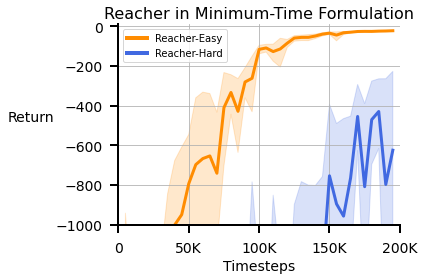

In [34]:
# Plot returns from numpy txt files with returns and episode lengths

envs = ["dm_reacher_easy", "dm_reacher_hard"]
color_palette = {
    "dm_reacher_easy": "darkorange",
    "dm_reacher_hard": "royalblue",
}
timeouts = [1000]
seed = 10
df = pd.DataFrame(columns=["step", "avg_ret", "seed", "timeout"])

for env in envs:
    for timeout in timeouts:
        all_paths = glob.glob(f"/home/vasan/scratch/min_time_paper/{env}/timeout={timeout}/returns/*_returns.txt")
        assert len(all_paths) > 0
        counter = 0
        for fp in all_paths:
            counter += 1
            data = np.loadtxt(fp)
            try:
                rets, timesteps = smoothed_curve(data[1], data[0], x_tick=5000, window_len=5000)
                for r, t in zip(rets, timesteps):
                    df = pd.concat([df, pd.DataFrame.from_records([{'env': env, 'timeout': timeout, 'seed':counter, 'step':t, 'avg_ret':r}])])
            except IndexError as e:
                print(f"Run {fp} incomplete. It was not added to the plot")

plt_formatter()
plt.xlim(0, 200000)
plt.ylim(-1000, 10)

sns.lineplot(x="step", y='avg_ret', data=df, hue='env', palette=color_palette)
title = "Reacher in Minimum-Time Formulation"
set_labels(title)

legend_elements = [Line2D([0], [0], color='darkorange', lw=4, label='Reacher-Easy'),
                   Line2D([0], [0], color='royalblue', lw=4, label='Reacher-Hard'),]
plt.legend(handles=legend_elements, loc='best')
plt.locator_params(axis='x', nbins=8)
plt.savefig(title+'.pdf', dpi=200)
plt.show()
plt.close()

In [35]:
# Plot returns from numpy txt files with returns and episode lengths

env_dict = {
    # "gr_reacher_hard": 50,
    # "gr_reacher_easy": 50,
    # "dm_reacher_hard": 100,
    "dm_reacher_easy": 100,
    # "gr_reacher_hard": 100,
    "gr_reacher_easy": 100,
}

x_tick=5000
window_len=5000
seed = 10
df = pd.DataFrame(columns=["step", "avg_ret", "seed", "timeout"])

for env, timeout in env_dict.items():
    all_paths = glob.glob(f"/home/vasan/scratch/min_time_paper/{env}/timeout={timeout}/returns/*_returns.txt")
    assert len(all_paths) > 0
    counter = 0
    for fp in all_paths:
        counter += 1
        data = np.loadtxt(fp)
        rets = data[1]
        timesteps = data[0]
        if 'gr' in env:
            rets = []
            timesteps = []   
            prev_steps = 0
            for r, t in zip(data[1], data[0]):
                if r == 0:
                    prev_steps += t           
                else:
                    rets.append(-(t+prev_steps))
                    timesteps.append(t+prev_steps)
                    prev_steps = 0
            rets = np.array(rets)
            timesteps = np.array(timesteps)
        try:
            rets, timesteps = smoothed_curve(rets, timesteps, x_tick=x_tick, window_len=window_len)
            for r, t in zip(rets, timesteps):                
                df = pd.concat([df, pd.DataFrame.from_records([{'env': env, 'timeout': timeout, 'seed':counter, 'step':t, 'steps_to_goal':-r}])])
        except IndexError as e:
            print(f"Run {fp} incomplete. It was not added to the plot")



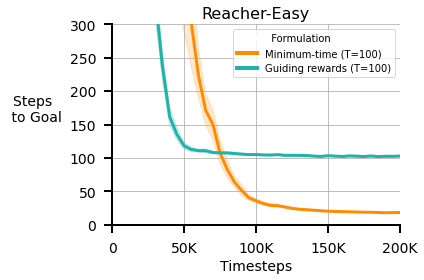

In [36]:
color_palette = {
    "gr_reacher_easy": "lightseagreen",
    "gr_reacher_hard": "darkmagenta",
    "dm_reacher_easy": "darkorange",
    "dm_reacher_hard": "royalblue",
}
    
plt_formatter()
plt.xlim(0, 200000)
plt.ylim(0, 300)

sns.lineplot(x="step", y='steps_to_goal', data=df, hue='env', palette=color_palette)
plt.ylabel("Steps to goal")

###
title = "Reacher-Easy"
# title = "Reacher-Hard"
if "Easy" in title:
    legend_elements = [Line2D([0], [0], color='white', lw=4, label='  Formulation'),
                        Line2D([0], [0], color='darkorange', lw=4, label='Minimum-time (T=100)'),
                       Line2D([0], [0], color='lightseagreen', lw=4, label='Guiding rewards (T=100)'),]
else:
    legend_elements = [Line2D([0], [0], color='white', lw=4, label='  Formulation'),
                        Line2D([0], [0], color='royalblue', lw=4, label='Minimum-time (T=100)'),
                       Line2D([0], [0], color='darkmagenta', lw=4, label='Guiding rewards (T=100)'),]
    ##

set_labels(title, xlabel="Timesteps", ylabel="Steps \n to Goal", labelpad=35)
plt.legend(handles=legend_elements, loc='best')
plt.locator_params(axis='x', nbins=8)
plt.tight_layout()
plt.savefig(f"{title}-steps-to-goal.pdf", dpi=200)
plt.show()
plt.close()

In [13]:
    for env in envs:
        tasks = next(os.walk(res_dir/env))[1]
        for task in tasks:
            df = pd.DataFrame(columns=["step", "avg_ret", "seed", "timeout"])
            timeouts = next(os.walk(res_dir/env/task))[1]
            for timeout in timeouts:
                seeds = next(os.walk(res_dir/env/task/timeout))[1]
                timeout_int = int(re.match(r'timeout=(\d+)', timeout).group(1))
                if env in ['Reacher-Easy', 'Reacher-Hard'] and task == 'visual' and timeout_int not in [50, 100, 500]:
                    continue

                for seed in seeds:
                    return_folder = res_dir/env/task/timeout/seed/'returns'
                    seed_int = int(re.match(r'seed=(\d+)', seed).group(1))
                    try:
                        filename = next(return_folder.glob("*.txt"))

                        with open(filename, 'r') as return_file:
                            epi_steps = [int(float(step)) for step in return_file.readline().split()]
                            returns = [int(float(ret)) for ret in return_file.readline().split()]
                
                        steps = 0
                        end_step = plot_interval
                        rets = []
                        for (i, epi_s) in enumerate(epi_steps):
                            steps += (epi_s + epi_s//timeout_int*20)
                            if steps > 200000:
                                break

                            ret = returns[i]
                            if steps > end_step:
                                if len(rets) > 0:
                                    df = df.append({'step':end_step, 'avg_ret':mean(rets), 'seed': seed_int, 'timeout': timeout_int}, ignore_index=True)                                     
                                    rets = []
                                while end_step < steps:
                                    end_step += plot_interval

                            rets.append(ret)
                        if len(rets) > 0:
                            df = df.append({'step':end_step, 'avg_ret':mean(rets), 'seed': seed_int, 'timeout': timeout_int}, ignore_index=True) 
                    except Exception as e:
                        print(str(e))

            if env == 'Reacher-Hard' and task == 'visual':
                plt.ylim(-1000, 0)
            else:
                plt.ylim(-400, 0)
            plt.xlim(0, 200000)
            set_curves()

            sns.lineplot(x="step", y='avg_ret', data=df, hue='timeout', palette=color_dict)
            task_title = 'Visual' if task == 'visual' else 'Non Visual'
            title = f'{task_title} {env}'
            set_labels(title)
            plt.savefig(title+'.pdf', dpi=200)
            plt.close()